# 模型评估与改进

In [1]:
# 本章深入学习模型评估与参数选择

# 将重点介绍监督方法 ,包括回归与分类 ,因为在无监督学习中 ,模型评估与选择通常是一个非常定性的过程

# 到目前为止 ,为了评估我们的监督模型 ,使用train_test_split函数将数据集划分为训练集和测试集
# 在训练集上调用fit方法来构建模型 ,并且在测试集上用score方法来评估这个模型
# 对于分类问题而言 ,就是计算正确分类的样本所占的比例

In [2]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 创建一个模拟数据集
X , y = make_blobs(random_state = 0)
# 将数据和标签划分为训练集和测试集
X_train , X_test , y_train , y_test = train_test_split(X ,y , random_state = 0)
# 将模型实例化 ,并用它来拟合训练集
logreg = LogisticRegression().fit(X_train , y_train)
# 在测试集上评估该模型
print('Test set score :{:.2f}'.format(logreg.score(X_test , y_test)))

Test set score :0.88


In [3]:
# 之所以将数据划分为训练集和测试集 ,是因为想要度量模型对前所未见的新数据的泛化性能
# 对模型在训练集上的拟合效果不感兴趣 ,而是想知道模型对于训练过程中没有见过的数据的预测能力

# 本章将从两个方面进行模型评估
# 首先介绍交叉验证 ,然后讨论评估分类和回归性能的方法
# 其中前者是一种更可靠的评估泛化性能的方法 ,后者实在默认度量(score方法给出的精度和R^2)之外的方法

# 还将讨论网格搜索 ,这是一种调节监督模型参数以获得最佳泛化性能的有效方法

## 交叉验证

In [4]:
# 交叉验证(cross-validation)是一种评估泛化性能的统计学方法 ,它比单词划分训练集和测试集的方法更加稳定、全面

# 在交叉验证中 ,数据被多次划分 ,并且需要训练多个模型 ,最常用的交叉验证是k折交叉验证(k-fold cross-validation)
# 其中k是由用户指定的数字 ,通常取5或10
# 在执行5折交叉验证时 ,首先将数据划分为(大致)相等的5部分 ,每一部分叫做折(fold)

# 接下来训练一系列模型
# 使用第1折作为测试集、其他折(2-5)作为训练集来训练第一个模型
# 利用2-5折中的数据来构建模型 ,然后在1折上评估精度
# 之后构建另一个模型 ,这次使用2折作为测试集 ,1、3、4、5折中的数据作为训练集
# 利用3、4、5折作为测试集继续重复这一过程
# 对于将数据划分为训练集和测试集的这5次划分 ,每一次都要计算精度
# 最后得到了5个精度值

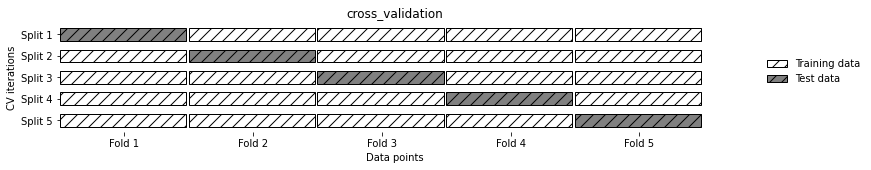

In [5]:
import mglearn
mglearn.plots.plot_cross_validation()

In [6]:
# 通常来说 ,数据的前五分之一是第1折 ,第二个五分之一是第2折 ,以此来推

### scikit-learn中的交叉验证

In [7]:
# scikit-learn 是利用 model_selection 模块中的 cross_val_score 函数来实现交叉验证的
# cross_val_score 函数的参数是想要评估的模型、训练数据与真实标签

In [8]:
# 在iris数据集上对LogisticRegression进行评估

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(max_iter = 5000)

scores = cross_val_score(logreg ,iris.data ,iris.target , cv = 3)
print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.98 0.96 0.98]


In [9]:
# cross_val_cross 执行3折交叉验证 ,可以通过修改cv参数来改变折数

scores = cross_val_score(logreg , iris.data , iris.target , cv = 5)
print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.96666667 1.         0.93333333 0.96666667 1.        ]


In [10]:
# 总结交叉验证精度的一种常用方法是计算平均值:

print('Average cross-validation score:{:.2f}'.format(scores.mean()))


Average cross-validation score:0.97


In [11]:
# 可以从交叉验证平均值中得出结论 ,预计模型的平均精度约为96%
# 观察5折交叉验证得到的所有5个精度值 
# 还可以发现 ,折与折之间的精度由较大的变化 ,范围为从100%精度到90%精度
# 这可能意味着模型强烈依赖于将某个折用于训练 ,但也可能只是因为数据集的数据量太小

### 交叉验证的优点

In [12]:
# 使用交叉验证而不是将数据单词划分为训练集和测试集 ,这中做法有以下优点
# 首先 ,train_test_split 对数据进行直接划分
# 如果使用交叉验证 ,每个样例都会刚好在测试集中出现一次:
# 每个样例位于一个折中 ,而每个折都在测试集中出现一次
# 因此 ,模型需要对数据集中所有样本的泛化能力都很好 ,才能让所有的交叉验证得分(及其平均值)都很高

In [13]:
# 对数据进行多次划分 ,还可以提供我们的模型对训练集选择的敏感性信息
# 对于iris数据集 ,观察到精度在90% 到 100% 之间
# 这是一个不小的范围 ,它告诉我们将模型应用于新数据是在最坏情况和最好情况下的可能表现

In [14]:
# 与数据的单次划分相比 ,交叉验证的另一个优点是对数据的使用更加高效
# 在使用train_test_split时 ,通常将75% 的数据用于训练 ,25%的数据用于评估
# 在使用5折交叉验证时 ,在每次迭代中可以使用4/5(80%)的数据来拟合模型
# 在使用10折交叉验证时 ,可以使用9/10(90%)的数据来拟合模型 
# 更多的数据通常可以得到更为精确的模型

In [15]:
# 交叉验证的缺点是增加了计算成本
# 现在要训练k个模型而不是单个模型 ,所以交叉验证的速度要比数据的单次划分大约慢k倍

In [16]:
# 重要的是要记住 ,交叉验证不是一种构建可应用于新数据的模型的方法
# 交叉验证不会返回一个模型
# 在调用cross_val_score时 ,内部会构建多个模型 ,但交叉验证的目的只是评估给定算法在特定数据集上训练后的泛化性能好坏

### 分层k折交叉验证和其他策略

In [17]:
# 将数据集划分为k折时 ,从数据的前k分之一开始划分

from sklearn.datasets import load_iris
iris = load_iris()
print('Iris labels:\n{}'.format(iris.target))

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [18]:
# 数据的前三分之一时类别0 ,中间三分之一是类别1 ,最后三分之一是类别2
# 想象一个在这个数据集上进行3折交叉验证
# 第一折将只包含0 ,所以在数据的第一次划分中 ,测试集将只包含类别0 ,而别的数据集只包含类别1和2
# 由于在3次划分中训练集和测试集的类别都不相同 ,因此这个数据集上的3折交叉验证精度为0
# 这没有什么帮助 ,因为在iris上可以得到比0% 好得多的精度

In [19]:
# 由于简单的k折策略在这里失效了 ,所以scikit-learn在分类问题中不使用这种策略
# 而是使用分层k折交叉验证(stratified k-fold cross-validation)
# 在分层交叉验证中 ,划分数据 ,使每个折中类别之间的比例与整个数据集中的比例相同

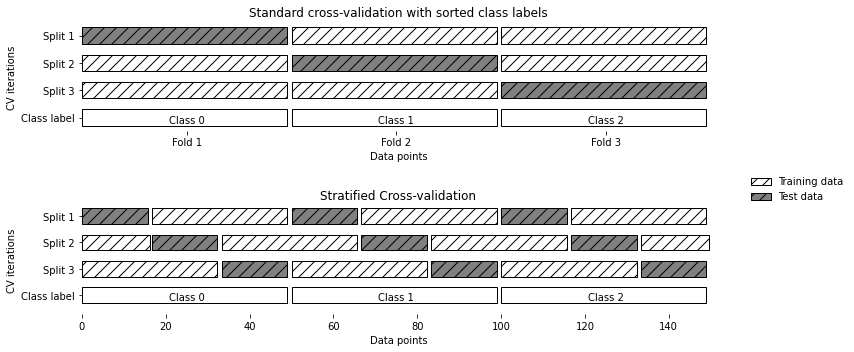

In [20]:
mglearn.plots.plot_stratified_cross_validation()

In [21]:
# 举个例子 ,如果90%的样本属于类别A而10%的样本属于类别B ,那么分层交叉验证可以确保 
# 在每个折中90%的样本属于类别A而10%的样本属于类别B

# 使用分层k折交叉验证而不是k折交叉验证来评估一个分类器
# 这通常是一个好主意 ,因为它可以对泛化性能做出更可靠的估计
# 在只有10% 的样本属于类别B的情况下 ,如果使用标准k折交叉验证
# 很可能某个折中只包含类别A的样本
# 利用这个折作为测试集的话 ,无法给出分类器整体性能的信息

# 对于回归问题 ,scikit-learn 默认使用标准k折交叉验证 
# 也可以尝试让每个折表示回归目标的不同取值 ,但折并不是一种常用的策略 ,也会让大多数用户感到意外

##### 1. 对交叉验证的更多控制

In [22]:
# 之前看到 ,可以利用cv参数来调节cross_val_score 所使用的折数
# 但scikit-learn 允许提供一个交叉验证分离器(cross-validation splitter)作为cv参数 
# 来对数据划分过程进行更精细的控制
# 对于大多数使用场景而言 ,回归问题默认的k折交叉验证与分类问题的分层k折交叉验证的表现都很好
# 但有些情况下可能希望使用不同的策略

# 比如说 ,想要在一个分类数据集上使用标准k折交叉验证来重现别人的结果

In [23]:
# 首先必须从model_selction模块中导入KFold 分类器类 ,并用想用折数来将其实例化

from sklearn.model_selection import KFold
kfold = KFold(n_splits = 5)

In [24]:
# 将kfold分离器对象作为cv参数传入cross_val_score
print('Cross-validation scores:\n{}'.format(cross_val_score(logreg , iris.data , iris.target , cv = kfold)))

Cross-validation scores:
[1.         1.         0.86666667 0.93333333 0.83333333]


In [25]:
# 通过这种方法 ,可以验证 ,在iris数据集上使用3折交叉验证(不分层)确实是一个非常糟糕的注意

kfold = KFold(n_splits = 3)
print('Cross_validation scores:\n{}'.format(cross_val_score(logreg , iris.data , iris.target ,cv = kfold)))

Cross_validation scores:
[0. 0. 0.]


In [26]:
# 在iris数据集中每个折对应一个类别 ,因此学不到任何内容
# 解决这个问题的另一种方法是将数据打乱来代替分层 , 以打乱样本按标签的排序
# 通过将KFold的shuffle参数设为True来实现这一点
# 如果将数据打乱 ,那么还需要固定random_state 以获得可重复的打乱结果
# 否则 ,每次运行cross_val_score将会得到不同的结果 ,因为每次使用的是不同的划分
# 在划分数据之前将其打乱可以得到更好的结果

In [27]:
kfold = KFold(n_splits = 3 , shuffle = True , random_state = 0)
print('Cross-validation scores:\n{}'.format(cross_val_score(logreg , iris.data , iris.target , cv = kfold)))

Cross-validation scores:
[0.98 0.96 0.96]


##### 2. 留一法交叉验证

In [28]:
# 另一种常用的交叉验证方式是留一法(leave-one-out)
# 可以将留一法交叉验证看作是每折只包含单个样本的k折交叉验证
# 对于每次划分 ,选择单个数据点作为测试集
# 这种方法可能非常耗时 ,特别是对于大型数据集来说 ,但在小型数据集上有时可以给出更好的估计结果

In [29]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg , iris.data ,iris.target , cv = loo)
print('Number of cv iterations:' , len(scores))
print('Mean accuracy:{:.2f}'.format(scores.mean()))

Number of cv iterations: 150
Mean accuracy:0.97


##### 3. 打乱划分交叉验证

In [30]:
# 另一种非常灵活的交叉验证策略是打乱划分交叉验证 (shuffle-split cross-validation)
# 在打乱划分交叉验证中 ,每次划分为训练集取样train_size个点 , 为测试集取样test_size个(不相交的)点
# 将折以划分方法重复n_iter次

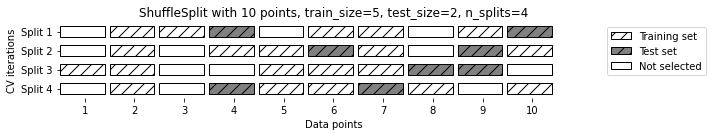

In [31]:
mglearn.plots.plot_shuffle_split()

# 显示的是对包含10个点的数据集运行4次迭代划分 ,每次的训练集包含5个点 ,测试集包含2个点
# (可以将train_size 和 test_size设为整数来表示这两个集合的绝对大小 ,也可以设为浮数点来表示站整个数据集的比例)

In [32]:
# 下边的代码将数据集划分为50%的训练集和50%的测试集 ,共运行10次迭代

from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size = 0.5 , train_size = 0.5 ,n_splits = 10)
scores = cross_val_score(logreg , iris.data , iris.target , cv = shuffle_split)
print('Cross-validation scores:\n{}'.format(scores))

Cross-validation scores:
[0.97333333 0.94666667 0.97333333 0.94666667 0.98666667 0.93333333
 0.96       0.93333333 0.93333333 0.94666667]


In [33]:
# 打乱划分交叉验证可以在训练集和测试集大小之外独立控制迭代次数
# 这有时是很有帮助的
# 它还允许在每次迭代中仅使用部分数据 ,这可以通过设置train_size 与 test_size 之和不等于1 来实现
# 这种方法对数据进行二次采样可能对大型数据上的实验很有用

# ShuffleSplit 还有以种分层的形式 ,其名称为StratifiedShuffleSpilt ,它可以为分类任何提供更可靠的结果

##### 4. 分组交叉验证

In [34]:
# 另一组非常常见的交叉验证适用于数据中的分组高度相关时

# 比如你想构建一个从人脸图片种识别情感的系统 ,并且收集了100个人的照片的数据集
# 其中每个人都进行了多次拍摄 ,分别展示了不同的情感 

# 我们的目标时构建一个分类器 ,能够正确识别未包含在数据集中的人的情感
# 可以使用默认的分层交叉验证来度量分类器的性能

# 但是这样的话 ,同一个人的照片可能会同时出现在训练集和测试集中
# 对于分类器而言 ,检测训练集中出现过的人脸情感比全新的人脸要容易的多
# 因此 ,为了准确评估模型对新的人脸的泛化能力,必须确保训练集和测试集中包含不同人的图像

In [35]:
# 为了实现这一点 ,可以使用GroupKFold ,它以groups 数组作为参数 ,可以用来说明照片中对应的是哪个人
# 这里的groups数组表示数据中的分组 ,在创建训练集和测试集的时候不应该将其分开,也不应该与类别标签弄混

In [36]:
# 数据分组的这种例子常见于医疗应用 , 你可能拥有来自同一名病人的多个样本 ,但想要将其泛化到新的病人
# 同样 ,在语音识别领域 ,你的数据集中可能包含同一名发言人的多条记录 ,但希望能够识别新的发言人的讲话 

In [37]:
# 下边这个实例用到了一个由groups数组指定分组的模拟数据集
# 这个数据集包含12个数据点 ,且对于每个数据点 ,groups 指定了该点所属的分组
# 一共分成4个组 ,前3个样本属于第一组 ,接下来的4个样本属于第二组

In [38]:
from sklearn.model_selection import GroupKFold
# 创建模拟数据集
X , y = make_blobs(n_samples = 12 , random_state = 0)
# 假设前3个样本属于同一组 ,接下来的4个属于同一组 ,以此类推
groups = [0,0,0,1,1,1,1,2,2,3,3,3]
scores = cross_val_score(logreg , X , y ,groups ,cv = GroupKFold(n_splits = 3))
print('Cross-validation scores:\n{}'.format(scores))

Cross-validation scores:
[0.75       0.6        0.66666667]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass groups=[0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [39]:
# 样本不需要按分组进行排序 ,这么做只是为了便于说明
# 基于这些标签计算得到的划分如下图

# 对于每次划分 ,每个分组都是整体出现在训练集或测试集中

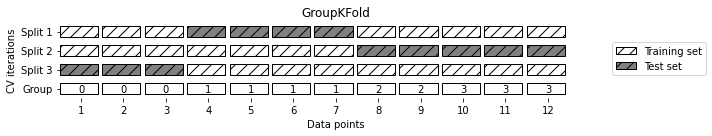

In [40]:
mglearn.plots.plot_group_kfold()

In [41]:
# scikit-learn中还有很多交叉验证的划分策略 ,适用于更多的使用场景
# 标准的KFold , StratifiedKFold 和 GroupKFold 是目前最常用的集中

## 网格搜索

In [42]:
# 通过调参来提升模型的泛化性能

In [43]:
# 最常用的方法就是网格搜索(grid search) ,它主要是指尝试我们关心的参数的所有可能组合

In [44]:
# 考虑有一个具有RBF(径向基函数)核的核SVM 的例子
# 它在SVC类中实现
# 它有2个重要参数 : 核宽度gamma 和 正则化参数c
# 假设希望尝试C的取值为0.001 , 0.01 , 0.1 , 1 , 10 和100
# gamma 也取这6个值

# 由于想要尝试的C和gamma 都有6个不同的取值 ,所以总共有36种参数组合
# 所有可能的组合组成了SVM的参数设置表(网格)

### 简单网格搜索

In [45]:
# 可以实现一个简单的网格搜索 ,在2个参数上使用for循环 ,对每种参数组合分别训练并评估一个分类器

In [46]:
# 简单的网格搜索实现
from sklearn.svm import SVC 
X_train , X_test , y_train , y_test = train_test_split(iris.data , iris.target , random_state = 0)
print('Size of training set:{}  size of test set:{}'.format(X_train.shape[0] , X_test.shape[0]))

best_score = 0

for gamma in [0.001 , 0.01 , 0.1 , 1 , 10 , 100]:
    for C in [0.001 , 0.01 , 0.1 , 1 , 10 , 100]:
        # 对每种参数组合都训练一个SVC
        svm = SVC(gamma = gamma , C = C)
        svm.fit(X_train ,y_train)
        # 在测试集上评估SVC
        score = svm.score(X_test , y_test)
        # 如果得到了更高的分数 ,则保存该分数和对应的参数
        if score > best_score:
            best_score = score 
            best_parameters = {'C': C , 'gamma':gamma}

print('Best score:{:.2f}'.format(best_score))
print('Best parameters:{}'.format(best_parameters))

Size of training set:112  size of test set:38
Best score:0.97
Best parameters:{'C': 100, 'gamma': 0.001}


### 参数过拟合的风险与验证集

In [47]:
# 上述结果可能过于乐观(或者就是错的) ,其原因如下
# 尝试了许多不同的参数 ,并选择了测试集上精度最高的那个 ,但这个精度不一定能推广到新数据上
# 由于使用测试数据进行调参 ,所以不能再用他来评估模型的好坏

# 最开始需要将数据划分为训练集和测试集也是因为这个原因
# 需要一个独立的数据集来进行评估 ,一个在创建模型时没有用到的数据集 

In [48]:
# 为了解决这个问题 ,一种方法是再次划分数据 ,这样就可以得到3个数据集:
# 用于构建模型的训练集 , 用于选择模型参数的验证集(开发集) , 用于评估所选参数性能的测试集

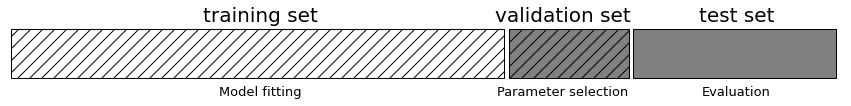

In [49]:
mglearn.plots.plot_threefold_split()

In [50]:
# 利用验证机选定最佳参数后 ,可以利用找到的参数设置重新构建一个模型
# 但是要同时在训练数据和验证数据上进行训练
# 这样我们可以利用尽可能多的数据来构建模型

In [51]:
from sklearn.svm import SVC
# 将数据划分为训练 + 验证集与测试集
X_trainval , X_test , y_trainval , y_test = train_test_split(iris.data , iris.target , random_state = 0)
# 将训练 + 验证集划分为训练集和验证集 
X_train , X_valid , y_train , y_valid = train_test_split(X_trainval , y_trainval , random_state = 1)
print('Size of training set:{}  size of validation set:{}  size of test set:{}\n'.format
      (X_train.shape[0] ,       X_valid.shape[0] ,          X_test.shape[0]))

best_score = 0

for gamma in [0.001 , 0.01 , 0.1 , 1 , 10 ,100]:
    for C in [0.001 , 0.01 , 0.1 , 1 , 10 ,100]:
        # 对每种参数组合都训练一个SVC
        svm = SVC(gamma = gamma , C = C)
        svm.fit(X_train , y_train)
        # 在验证集上评估SVC
        score = svm.score(X_valid , y_valid)
        # 如果得到了更高的分数 ,则保存该分数和对应的参数
        if score > best_score:
            best_score = score 
            best_parameters = {'C' : C , 'gamma' : gamma}
            
# 在训练+验证集上重新构建一个模型 ,并在测试集上进行评估
svm = SVC(**best_parameters)
svm.fit(X_trainval , y_trainval)
test_score = svm.score(X_test , y_test)
print('Best score on validation set : {:.2%}'.format(best_score))
print('Best parameters:' , best_parameters)
print('Test set score with best parameters : {:.2%}'.format(test_score))

Size of training set:84  size of validation set:28  size of test set:38

Best score on validation set : 96.43%
Best parameters: {'C': 10, 'gamma': 0.001}
Test set score with best parameters : 92.11%


In [52]:
# 验证集上最高分数是96% ,这比之前较低
# 可能是因为使用更少的数据来训练模型(现在X_train更小 ,因为对数据集做了两次划分)

# 但测试集上的分数(这个分数实际反应了模型的泛化能力)更低,为92%
# 因此只能生成对92%的新数据正确分类 ,而不是之前认为的97%

In [53]:
# 训练集 ,验证集和测试集之间的区别对于在实践中应用机器学习方法至关重要
# 任何根据测试集精度所做的选择都会将测试集的信息'泄露'(leak)到模型中

# 因此,保留一个单独的测试集是很重要的 ,它仅用于最终评估
# 好的做法是利用训练集和验证集的组合完成所有的探索性分析和模型选择
# 并保留测试集用于最终评估
# 即使对于探索性可视化也是如此

# 严格来说 ,在测试集上对不止一个模型进行评估并选择更好的那个 ,将会导致对模型精度过于乐观的估计

### 带交叉验证的网格搜索

In [54]:
# 虽然将数据划分为训练集 ,验证集和测试集的方法是可行的 ,也相对常用
# 但这种方法对数据的划分方法相当敏感

# 为了得到对泛化性能的更好估计 ,可以使用交叉验证来评估每种参数组合的性能
# 而不是仅将数据单次划分为训练集与验证集

In [55]:
import numpy as np

for gamma in [0.001 , 0.01 , 0.1 , 1 , 10 ,100]:
    for C in [0.001 , 0.01 , 0.1 , 1 , 10 ,100]:
        # 对于每种参数组合都训练一个SVC
        svm = SVC(gamma = gamma , C = C)
        # 执行交叉验证
        scores = cross_val_score(svm , X_trainval , y_trainval , cv = 5)
        # 计算交叉验证平均精度
        score = np.mean(scores)
        # 如果得到了更高的分数 ,则保存该分数和对应的参数
        if score > best_score:
            best_score = score 
            best_parameters = {'C' : C , 'gamma' : gamma}
            
# 在训练+验证集上重新构建一个模型
svm = SVC(**best_parameters)
svm.fit(X_trainval , y_trainval)

SVC(C=10, gamma=0.1)

In [56]:
# 要想使用5折交叉验证对 C 和gamma 特定取值的SVM 的精度进行评估 ,需要训练 36 * 5 = 180个模型
# 使用交叉验证的主要缺点就是训练所有这些模型所需花费的时间

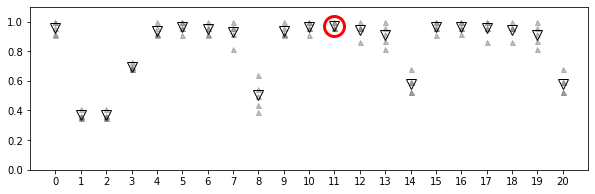

In [57]:
try:
    mglearn.plots.plot_cross_val_selection()  # 需要matplotlib==3.0.3版本
except ValueError:
    print('')

In [58]:
# 对于某种参数设置 ,需要计算5个精度值 ,交叉验证的每次划分都要计算一个精度值
# 然后 ,对每种参数设置计算平均验证精度
# 最后 ,选择平均验证精度最高的参数 , 用圆圈标记

In [59]:
# 交叉验证是在特定数据集上对给定算法进行评估的一种方法
# 但它通常与网格搜索等参数搜索方法结合使用
# 因此 ,许多人使用交叉验证(cross_validation) 这一术语来通俗地指带交叉验证的网格搜索

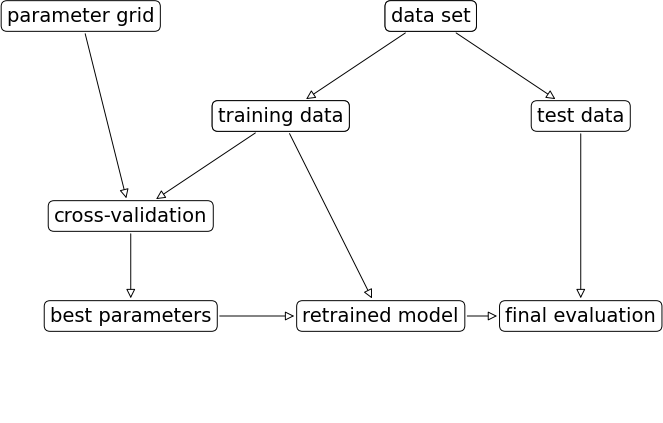

In [60]:
mglearn.plots.plot_grid_search_overview()

In [61]:
# 由于带交叉验证的网格搜索是一种常用的调参方式 ,因此scikit-learn提供了GridSearchCV类 
# 它以估计器(estimator)的形式实现了这种方法

# 要使用GridSearchCV类 
# 首先需要用一个字典指定要搜索的参数
# 然后FridSearchCV会执行所有必要的模型拟合

# 字典的键是要调节的参数名称
# 字典的值是想要尝试的参数设置

In [62]:
param_grid = {'C' : [0.001 , 0.01 , 0.1 , 1 , 10 , 100] , 'gamma' : [0.001 , 0.01 , 0.1 , 1 , 10 , 100]}
print('Parameter grid:\n{}'.format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [63]:
# 现在可是使用模型(SVC) ,要搜索的参数网络(param_grid)与要使用的交叉验证策略(比如5折分层交叉验证)
# 将GridSearchCV类实例化

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
grid_search = GridSearchCV(SVC() , param_grid , cv = 5)

In [65]:
# GridSearchCV 将使用交叉验证来代替之前用过的划分训练集和验证集方法
# 但是 ,仍需要将数据划分为训练集和测试集 ,以避免参数过拟合

In [66]:
X_train , X_test , y_train ,y_test = train_test_split(iris.data , iris.target , random_state = 0)

# 创建的grid_search对象行为就像是以个分类器 ,可以对它调用标准的fit , predict 和score 方法
# 但在调用fit时 ,会对param_grid指定的每种参数组合都运行交叉验证

grid_search.fit(X_train , y_train)

# 拟合GridSearchCV对象不仅会搜索最佳参数 ,还会利用得到最佳交叉验证性能的参数在整个训练数据集上自动拟合一个新模型
# GridSearchCV类提供了以各非常方便的接口 ,可以用predict 和score方法来访问重新训练过的模型
# 为了评估找到最佳参数的泛化能力 ,可以在测试集调用score

print('Test set score :{:.2f}'.format(grid_search.score(X_test , y_test)))

Test set score :0.97


In [67]:
# 利用交叉验证选择参数 ,实际上找到了一个在测试集上精度为97%的模型
# 重要的是 ,没有使用测试集来选择参数
# 找到的参数保存在 best_param_ 属性中 ,而交叉验证最佳精度保存在 best_score_ 中

print('Best parameters:{}'.format(grid_search.best_params_))
print('Best cross-validation score:{:.2f}'.format(grid_search.best_score_))

Best parameters:{'C': 10, 'gamma': 0.1}
Best cross-validation score:0.97


In [68]:
# 同样 ,注意不要将best_score_ 与模型在测试集上调用score方法计算得到的泛化性能弄混
# 使用score方法(或者对predict方法的输出进行评估)采用的是在整个训练集上训练的模型
# 而best_score_ 属性保存的是交叉验证的平均精度 ,是在训练集上进行交叉验证得到的

In [69]:
# 能够访问实际找到的模型 ,这有时是很有帮助的
# 比如查看系数或者特征重要性
# 可以用best_estimator_ 属性来访问最佳参数对应的模型 ,它是在整个训练集上训练得到的

In [70]:
print('Best estimator :\n{}'.format(grid_search.best_estimator_))

# 由于grid_search 本身具有predict 和 score 方法
# 所以不需要使用best_estimator_ 来进行预测或评估模型

Best estimator :
SVC(C=10, gamma=0.1)


##### 1. 分析交叉验证的结果

In [71]:
# 将交叉验证的结果可视化通常有助于理解模型泛化能力对所搜索参数的依赖关系
# 由于运行网格搜索的计算成本相当高 ,所以通常最好从相对比较稀疏且较小的网格开始搜索
# 然后可以检查交叉验证网格搜索的结果 ,可能也会扩展搜索范围
# 网格搜索的结果可以在 cv_results_ 属性中找到 ,它是一个字典 ,其中保存了搜索的所有内容

In [72]:
import pandas as pd 
# 转换为DataFrame(数据框)
results = pd.DataFrame(grid_search.cv_results_)
# 显示前五行
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000801,0.0004,0.000399,0.000489,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
1,0.000800,0.0004,0.000200,0.000401,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
2,0.000800,0.0004,0.000200,0.000400,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
3,0.000800,0.0004,0.000000,0.000000,0.001,1,"{'C': 0.001, 'gamma': 1}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22
4,0.000800,0.0004,0.000199,0.000399,0.001,10,"{'C': 0.001, 'gamma': 10}",0.347826,0.347826,0.363636,0.363636,0.409091,0.366403,0.022485,22


In [73]:
# results 中每一行对应一种特定的参数设置
# 对于每种参数设置 ,交叉验证所有划分的结果都被记录下来 ,所有划分的平均值和标准差也被记录下来
# 由于搜索的是一个二维参数网格(C 和 gamma) ,所以最适合用热图可视化

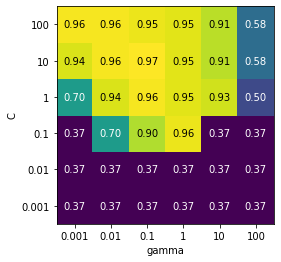

In [74]:
# 首先提取平均验证分数 ,然后改变分数数组的形状 ,使其坐标轴分别对应于C 和 gamma

scores = np.array(results.mean_test_score).reshape(6,6)
import matplotlib.pyplot as plt

# 对交叉验证平均分数作图
mglearn.tools.heatmap(scores , xlabel = 'gamma' , xticklabels = param_grid['gamma'] , 
                      ylabel = 'C' ,yticklabels = param_grid['C'] ,cmap = 'viridis')
plt.show()

In [75]:
# 热图中的每个点对应于运行一次交叉验证以及一种特定的参数设置
# 颜色表示交叉验证的精度 : 浅色表示高精度 ,深色表示低精度

# 可以观察到SVC对参数设置非常敏感
# 对于许多种参数设置 ,精度都在40%左右 ,这是非常糟糕的
# 对于其他参数设置 ,精度约为96% 

# 可以从这张图看出以下几点:
# 首先 ,调节的参数对于获得良好的性能非常重要
# 这两个参数(C 和 gamma)都很重要 ,因为调节它们可以将精度从40%提高到96%
# 此外 ,在选择的范围中也可以看到输出发生了显著的变化
# 同样重要的是要注意 ,参数的范围要足够大 :每个参数的最佳取值不能位于图像的边界上

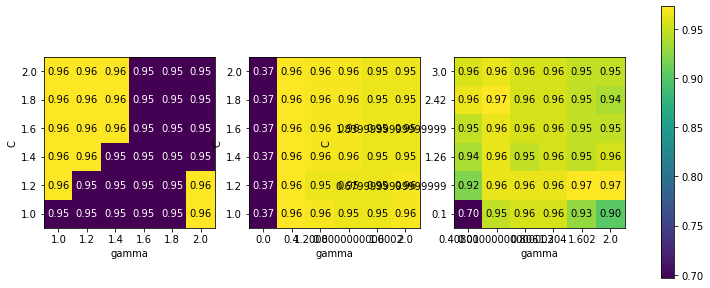

In [76]:
fig , axes = plt.subplots(1 , 3 , figsize = (13 , 5))

param_grid_linear = {'C':np.linspace(1 ,2, 6) , 'gamma':np.linspace(1 ,2, 6)}

param_grid_one_log = {'C':np.linspace(1 ,2, 6) , 'gamma':np.linspace(0 ,2, 6)}

param_grid_range = {'C':np.linspace(0.1 ,3, 6) , 'gamma':np.linspace(0.01 ,2, 6)}

for param_grid ,ax in zip([param_grid_linear , param_grid_one_log ,param_grid_range] , axes):
    grid_search = GridSearchCV(SVC() ,param_grid ,cv = 5)
    grid_search.fit(X_train , y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6,6)
    
    #  对交叉验证平均分数作图
    scores_image = mglearn.tools.heatmap(scores , xlabel = 'gamma' ,ylabel = 'C' , xticklabels = param_grid['gamma'] , 
                                         yticklabels = param_grid['C'] , cmap = 'viridis' , ax = ax)
    
plt.colorbar(scores_image , ax = axes.tolist())
plt.show()

In [77]:
# 第一张图没有显示任何变化 ,整个参数网格的颜色相同
# 在这种情况下 ,这是由参数C 和 gamma不正确的缩放以及不正确的范围造成的
# 但如果对于不同的参数设置都看不到精度的变化 ,也可能是因为这个参数根本不重要
# 通常最好在开始时尝试非常极端的值 ,以观察改变参数是否会导致精度发生变化

In [78]:
# 第二张图显示的是垂直条形模式 
# 折表示只有gamma 的设置对精度有影响
# 这可能意味着gamma参数的搜索范围是我们所关心的 ,而C参数并不是 - 也可能意味着C参数并不重要

In [79]:
# 第三张图中C 和 gamma 对应的精度都有变化
# 但可以看到 ,在图像的整个左下角都没有发生什么有趣的事情
# 在后边的网格搜索中可以不考虑非常小的值
# 最佳参数设置出现在右上角
# 由于最佳参数位于图像的边界 ,所以可以认为 ,在这个边界之外可能还有更好的取值 ,可能希望改变搜索范围以包含这一区域内的更多参数

In [80]:
# 基于交叉验证分数来调节参数网格是非常好的
# 也是探索不同参数的重要性的好方法
# 但是 ,不应该在最终测试集上测试不同的参数范围 - 前面说过 ,只有确切直到了想要使用的模型 ,才能对测试集进行评估

##### 2. 在非网格的空间中搜索

In [81]:
param_grid = [{'kernel':['rbf'] ,'C':[0.001 , 0.01 , 0.1 ,1 ,10 ,100] ,'gamma':[0.001 , 0.01 , 0.1 ,1 ,10 ,100]},
              {'kernel':['linear'] ,'C':[0.001 , 0.01 , 0.1 ,1 ,10 ,100]}]

print('List of grid:\n{}'.format(param_grid))

List of grid:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [82]:
# 在第一个网格中 ,kernel参数始终等于'rbf'(注意kernel是一个长度为1 的列表),而C 和gamma都是变化的
# 在第二个网格中 ,kernel参数始终等于'linear' ,只有C是变化的

In [83]:
grid_search = GridSearchCV(SVC() , param_grid , cv = 5)
grid_search.fit(X_train , y_train)
print('Best parameters:{}'.format(grid_search.best_params_))
print('Best cross-validation score:{:.2f}'.format(grid_search.best_score_))

Best parameters:{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score:0.97


In [84]:
# 再次查看 cv_results 
# 如果 kernel 等于 'linear' ,那么只有C是变化的

In [85]:
results = pd.DataFrame(grid_search.cv_results_)
# 给出的是转置之后的表格 ,这样更适合页面显示
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00100021,0.000600433,0.000400543,0.000399637,0.000200081,0.000800657,0.000400162,0,0.000399971,0.000400162,...,0.000399923,0.000599909,0.000799656,0.000800705,0,0.0006001,0.000400066,0,0,0.00059967
std_fit_time,2.01967e-06,0.000490252,0.000490564,0.000489454,0.000400162,0.00040033,0.000490096,0,0.000489862,0.000490098,...,0.000489805,0.000489827,0.000399831,0.000400355,0,0.00048998,0.000489979,0,0,0.000489631
mean_score_time,0.000199938,0.000400209,0.000400591,0,0.000800323,0.000200176,0,0.00100031,0.000600147,0.000199699,...,0.000199842,0.000200319,0,0.000399828,0.000200653,0.000399494,0,0,0.000599813,0.000400686
std_score_time,0.000399876,0.000490155,0.000490622,0,0.000400163,0.000400352,0,2.4314e-07,0.000490019,0.000399399,...,0.000399685,0.000400639,0,0.000489688,0.000401306,0.000489279,0,0,0.000489746,0.000490738
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1,0.956522,0.869565,0.521739,0.347826,0.869565,1,1,1,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1,0.956522


##### 3. 使用不同的交叉验证策略进行网格搜索

In [86]:
# 与cross_val_score 类似 ,GridSearchCV 对分类问题默认使用分层k折交叉验证 ,对回归问题默认使用k折交叉验证
# 但是 ,可以传入任何交叉验证分离器作为GridSearchCV 的 cv 参数
# 特别地 ,如果只想将数据单词划分为训练集和测试集 ,你可以使用ShuffleSplit 或 StratifiedShuffleSplit
# 并设置 n_iter = 1 
# 这对于非常大的数据集或非常慢的模型可能会有帮助

##### (1) 嵌套交叉验证

In [87]:
# 在前面的例子中 ,先介绍了将数据单词划分为训练集 ,验证集与测试集
# 然后介绍了先将数据划分为训练集和测试集 ,再在训练集上进行交叉验证
# 但前面在使用GridSearchCV时 ,仍然将数据单词划分为训练集和测试集
# 这可能对导致结果不稳定 ,也过于依赖数据的此次划分

# 可以再深入一点
# 不是只将原始数据一次划分为训练集和测试集
# 而是使用交叉验证进行多次划分 ,这就是所谓的嵌套交叉验证(nested cross-validation)
# 在嵌套交叉验证中 ,有一个外层循环 , 遍历将数据划分为训练集和测试集的所有划分
# 对于每种划分都运行一次网格搜索(对于外层循环的每种划分可能会得到不同的最佳参数)
# 然后 ,对于每种外层划分 , 利用最佳参数设置计算得到测试集分数

In [88]:
# 这一过程的结果是由分数组成的列表 - 不是一个模型 ,也不是一种参数设置
# 这些分数告诉我们在网格找到的最佳参数下模型的泛化能力好坏
# 由于嵌套交叉验证不提供可用于新数据的模型
# 所以在寻找可用于未来数据的预测模型时很少用到它
# 但是 ,它对于评估给定模型在特定数据集上的效果很有用

In [89]:
# 在scikit-learn 中实现嵌套交叉验证很简单
# 调用cross_val_score ,并用GridSearchCV 的一个实例作为模型:

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score

iris = load_iris()

param_grid = {
  'C': [0.001, 0.01, 0.1, 1, 10, 100],
  'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

scores = cross_val_score(GridSearchCV(SVC() , param_grid , cv = 5) , iris.data , iris.target , cv = 5)
print('Cross-validation : ' ,scores)
print('Mean cross-validation score :' , scores.mean())

Cross-validation :  [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean cross-validation score : 0.9800000000000001


In [90]:
# 嵌套交叉验证的结果可以总结为'SVC 在iris数据集上的交叉验证平均精度为98%' - 不多也不少

In [91]:
# 在内层循环和外层循环中都使用了分层5折交叉验证
# 由于param_grid 包含36种参数组合 ,所以需要构建 36*5*5 = 900个模型
# 导致嵌套交叉验证过程的代价很高
# 这里在内层循环和外层循环种使用相同的交叉验证分离器 ,但这不是必须的
# 可以在内层循环和外层循环种使用交叉验证策略的任意组合

In [92]:
# 将其展开为for循环

def nested_cv(X , y , inner_cv , outer_cv , Classifier , parameter_grid):
    outer_scores = []
    # 对于外层交叉验证的每次数据划分 ,split方法返回索引值
    for training_samples , test_samples in outer_cv.split(X ,y):
        # 利用内层交叉验证找到最佳验证
        best_parms = {}
        best_score = -np.inf
        # 遍历参数
        for parameters in parameter_grid:
            # 在内层划分中累加分数
            cv_scores = []
            # 遍历内层交叉验证
            for inner_train , inner_test in inner_cv.split(X[training_samples] , y[training_samples]):
                # 对于给定的参数和训练数据来构建分类器
                clf = Classifier(**parameters)
                clf.fit(X[inner_train] ,y[inner_train])
                # 在内层测试集上进行评估
                score = clf.score(X[inner_test] ,y[inner_test])
                cv_scores.append(score)
            # 计算内层交叉验证的平均分数
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # 如果比前面的模型都要好 ,则保存其参数
                best_score = mean_score
                best_params = parameters
        # 利用外层训练集和最佳参数来构建模型
        clf = Classifier(**best_params)
        clf.fit(X[training_samples] , y[training_samples])
        # 评估模型
        outer_scores.append(clf.score(X[test_samples] , y[test_samples]))
    return np.array(outer_scores)

In [93]:
from sklearn.model_selection import ParameterGrid ,StratifiedKFold
scores = nested_cv(iris.data , iris.target ,StratifiedKFold(5) , StratifiedKFold(5) , SVC , ParameterGrid(param_grid))
print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.96666667 1.         0.96666667 0.96666667 1.        ]


##### (2) 交叉验证与网格搜索并行

In [94]:
# 虽然在许多参数上运行网格搜索和在大型数据集上运行网格搜索的计算量可能更大 
# 但令人尴尬的是 ,这些计算都是并行的(parallel)

# 这也就是说 ,在一种交叉验证划分下使用特定参数来设置来构建一个模型
# 与利用其他参数的模型是完全独立的
# 这使得网格搜索与交叉验证成为多个CPU内核或集群上并行化的理想选择

# 可以将n_jobs参数设置为想要使用的CPU内核数量
# 从而在GridSearchCV 和 cross_val_score 中使用多个内核
# 可以设置 n_jobs = -1 来使用所有可用的内核

In [95]:
# scikit-learn不允许并行操作的嵌套
# 因此 ,如果在模型(比如随机森林)中使用了n_jobs 选项 ,那么就不能在GridSearchCV使用它来搜索这个模型
# 如果数据和模型都非常大 ,那么使用多个内核可能会占用大量内存
# 应该在并行构建大型模型时监视内存的使用情况

## 评估指标与评分

In [96]:
# 到目前为止 , 使用精度(正确分类的样本所占的比例)来评估分类性能
# 使用R^2 来评估回归性能
# 但是 ,总结监督模型在给定数据集上的表现有多种方法 ,这两个指标只是其中两种
# 在实践中 ,这些评估指标可能不适用于你的应用\
# 在选择模型与调参时 ,选择正确的指标是很重要的

### 牢记最终目标

In [97]:
# 在实践中 ,通常不仅对精确的预测感兴趣 ,还希望将这些预测结果用于更大的决策过程
# 在选择机器学习指标之前, 应该考虑应用的高级目标 ,这通常被成为商业指标(business metric)
# 对于一个机器学习应用 ,选择特定算法的结果被成为商业影响(business impact)
# 高级目标可能是避免交通事故或者减少入院人数 ,也可能是吸引更多的网站用户或者让用户在你的商店中画更多的钱
# 在选择模型或调参时 ,应该选择对商业指标具有最大正面影响的模型或参数值
# 这通常是很难的 ,因为要想评估某个模型的商业影响 ,可能需要将它放在真实的生产环境中

In [98]:
# 在开发的初期阶段调参 ,仅为了测试就将模型投入生产环境往往是不可行的
# 因为可能涉及很高的商业风险或个人风险

# 找到与原始商业目标最接近的可评估的指标也很有用
# 应尽可能使用这个最接近的指标来进行模型评估与选择
# 评估的结果可能不是一个数字 - 算法的结果可能是顾客多了10% 
# 但美味顾客的花费减少了15% - 但它应该给出选择一个模型而不选另一个所造成的预期商业影响

In [99]:
# 首先讨论二分类这一重要特例的指标 ,然后转向多分类问题 ,最后讨论回归问题

### 二分类指标

In [100]:
# 二分类可能是实现中最常见的机器学习应用 ,也是概念最简单的应用
# 但是 ,即使是评估这个简单任务也仍有一些注意事项
# 在深入研究替代指标之前 ,先看一下测量精度可能会如何误导我们
# 对于二分类问题 ,通常会说正类(positive class) 和反类(negative class) ,而正类是我们要寻找的类

##### 1. 错误类型

In [101]:
# 通常来说 ,精度并不能很好地度量预测性能 ,因为所犯错误的数量并不包含我们感兴趣的所有信息

# 错误的阳性预测叫做假正例(false positive) -> 第一类错误(type I error)  (统计学)
# 错误的隐形预测叫做假返利(false negative) -> 第二类错误(type II error) (统计学)

# 在商业应用中 ,可以为两种类型的错误分配美元值 ,即用美元而不是精度来度量某个预测结果的错误 
# 对于选择使用哪种商业的商业决策而言 ,这种方法可能更有意义

##### 2. 不平衡数据集

In [102]:
# 如果在两个类别中 ,一个类别的出现次数比另一个多很多 ,那么错误类型将发挥重要作用

# 如中一个类别比另一个类别出现次数多很多的数据集 ,通常叫做不平衡数据集(imbalanced dataset)
# 或者具有不平衡类别的数据集(dataset with imbalanced classes)

# 在实际当中 ,不平衡数据才是常态 ,而数据中感兴趣实践的出现次数相同或相似的情况非常罕见

In [103]:
# 假设在构建了一个在电极策瑜任务中精度达到99%的分类器

# 这告诉你什么?
# 99%的精度听起来令人印象深刻 ,但是它并没有考虑类别不平衡
# 不必构建机器学习模型 ,始终预测'未点击'就可以得到99%的精度
# 另一方面 ,即使是不平衡数据 ,精度达到99%的模型实际上也是相当不错的
# 但是 ,精度无法帮助我们区分不变的'未点击'模型与潜在的优秀模型

In [104]:
# 为了便于说明 ,将digits 数据集中的数字9与其他九个类别加以区分 ,从而创建一个9:1的不平衡数据集

from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target ==9

X_train , X_test , y_train , y_test = train_test_split(digits.data , y , random_state = 0)

# 可以使用DummyClassifier 来始终预测多数类(这里是非'9'),以查看精度提供的信息量有多么少

from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train ,y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print('Unique predicted labels:{}'.format(np.unique(pred_most_frequent)))
print('Test score:{:.2f}'.format(dummy_majority.score(X_test , y_test)))

# 得到了接近90%的精度 ,却没有学到任何内容
# 这个结果可能看起来非常好 ,但根据具体问题 ,也可能是仅预测了一个类别

Unique predicted labels:[False]
Test score:0.90


In [105]:
# 将这个结果与使用一个真实分类器的结果进行对比

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 2).fit(X_train , y_train)
pred_tree = tree.predict(X_test)
print('Test score:{:.2f}'.format(tree.score(X_test , y_test)))

Test score:0.92


In [106]:
# 从精度来看 ,DecisionTreeClassfier 仅比常数预测稍好一点
# 这可能表示使用DecisionTreeClassifier 的方法有误 ,也可能是因为精度实际上在这里不是一个很好的变量

In [107]:
# 为了便于对比 ,在评估两个分类器 ,LogisticRegression 与默认的DummyClassifier 其中后者进行随机预测
# 但预测类别的比例与训练集中的比例相同

In [108]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier().fit(X_train , y_train)
pred_dummy = dummy.predict(X_test)
print('dummy score:{:.2f}'.format(dummy.score(X_test , y_test)))

logreg = LogisticRegression(C = 0.1 , max_iter = 5000).fit(X_train , y_train)
pred_logreg = logreg.predict(X_test)
print('logreg score:{:.2f}'.format(logreg.score(X_test , y_test)))

dummy score:0.81
logreg score:0.98


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [109]:
# 显而易见 ,产生随机输出的虚拟分类器是所有分类器中最差的(精度最低),而LogisticRegression则给出了非常好的结果
# 但是 ,即使是随机分类器也得到了超过80%的精度
# 这样很难判断哪些结果是真正有帮助的

# 这里的问题在于 ,想要对这种不平衡数据的预测性能进行量化, 精度并不是一种合适的度量
# 接下来探索在选择模型方面能够提供更好指导的其他指标
# 我们特别希望有有一个指标可以告诉我们 ,一个模型比'最常见'预测(由pred_most_frequent给出)或随机预测(由pred_dummy给出)要好多少
# 如果用以各指标来评估模型 ,那么这个指标应该能够淘汰这些无意义的预测

##### 3. 混淆矩阵

In [110]:
# 对于二分类问题的评估结果 ,一种最全面的表示方法是使用混淆矩阵(confusion matrix)
# 利用confusion_matrix函数来检查LogisticRegression的预测结果
# 已经将测试集上的预测结果保存在pred_logreg中:

from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test , pred_logreg)
print('Confusion matrix:\n{}'.format(confusion))

Confusion matrix:
[[402   1]
 [  6  41]]


In [111]:
# confusion_matrix 的输出是一个 2*2数组 ,其中行对应于真实的类别 ,列对应于预测的类别
# 数组中每个元素给出属性该行对应类别(这里是'非9' 和'9')的样本被分类到该列对应类别中的数量

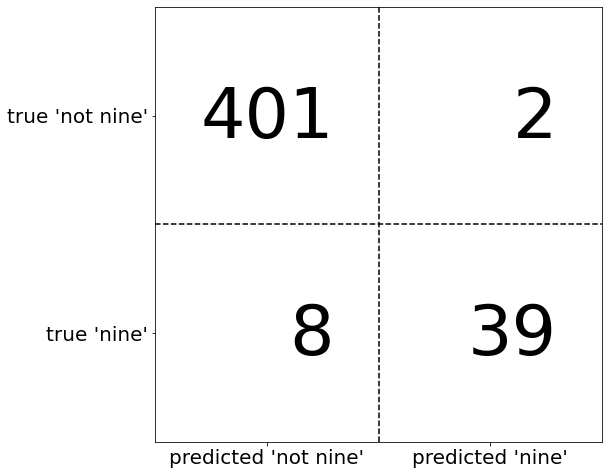

In [112]:
mglearn.plots.plot_confusion_matrix_illustration()

In [113]:
# 混淆矩阵主对角线上的元素对应于正确的分类 , 而其他元素则告诉我们一个类别中有多少样本被错误地划分到其他类别中

In [114]:
# 如果将'9'做为正类 ,那么就可以将混淆矩阵的元素于前面介绍过的假正例(false positive) 和假反例(false negative)
# 为了使图像更加完整 ,将正类中正确分类的样本成为真正例(true positive) ,将反类中正确分类的样本成为真反例(true negative)
# 这些属于通常缩写为FP ,FN ,TP 和 TN

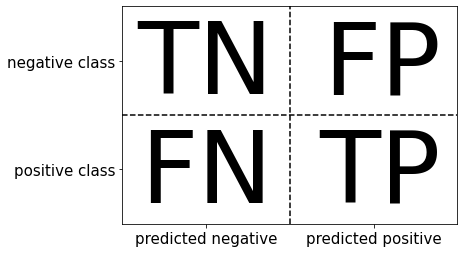

In [115]:
mglearn.plots.plot_binary_confusion_matrix()

In [116]:
# 用混淆矩阵来比较前面拟合过的模型(两个虚拟模型 ,决策树 ,Logistic回归)

In [117]:
print('Most frequent class:')
print(confusion_matrix(y_test , pred_most_frequent))
print('\nDummy model:')
print(confusion_matrix(y_test ,pred_dummy))
print('\nDecision tree:')
print(confusion_matrix(y_test , pred_tree))
print('\nLogistic Regression')
print(confusion_matrix(y_test , pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[364  39]
 [ 45   2]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression
[[402   1]
 [  6  41]]


In [118]:
# 观察混淆矩阵 ,很明显可以看出pred_most_frequent有问题 ,因为他总是预测同一个类别
# 另一方面 ,pred_dummy的真正例数量很少(4个) ,特别是与假反例和假正例的数量相比
# 假正例的数量比真正例还多

# 决策树的预测比虚拟预测更有意义 ,即使二者精度几乎相同

# 最后 ,可以看到 ,Logistic回归在各方面都比pred_tree要好:
# 它的真正例和真反例的数量更多 ,而假正例和假反例的数量更少

# 从这个对比中可以明确看出 ,只有决策树和Logistic回归给出了合理的结果
# 并且Logistic回归的效果全面好于决策树 ,但是 ,检查整个混淆矩阵有点麻烦

# 虽然通过观察矩阵的各个方面得到了很多深入见解 ,但是这个过程是人工完成的 , 也是非常定性的

与精度的关系 ->
总结混淆矩阵结果的方法 - <span class="burk">计算精度</span>
Accuracy = (TP + TN)/(TP + TN + FP + FN) -> T / (T + F)

换句话说 ,精度是正确预测的数量(TP 和 TN)除以所有样本的数量(混淆矩阵中所由元素的总和)

Accuracy = $\frac{TP + TN}{(TP + TN + FP + FN)}$ 

准确率 , 召回率 与f-分数
总结混淆矩阵还有几种方法 ,其中最常见的就是准确率和召回率

<span class="burk">准确率(precision)</span>度量的是被预测为整理的样本中有多少是真正的正例
Precision = TP / (TP + FP)

<span class="mark">Precision = $\frac{TP}{TP + FP}$</span>

<br>如果目标是限制假正例的数量 ,那么可以使用准确率作为性能指标 <br>
<br>模型不会产生很多假正例是很重要的<br>
<br>换句话说 ,模型的准确率很高<br>
<br><span class="burk">准确率也被成为阳性预测值(positive predictive value , PPV)</span><br>

另一方面 ,<span class="burk">召回率(recall)</span>度量的是正类样本中有多少被预测为正类

Recall = $\frac{TP}{TP + FN}$

In [119]:
# 如过需要找出所有的正类样本 ,即避免假反例是很重要的情况下 ,那么可以使用召回率作为性能指标
# 召回率的其他名字有灵敏度(sensitivity) ,命中率(hit rate) 和真正利率(true positive rate ,TPR)

In [120]:
# 在优化召回率与优化准确率之间需要折中
# 将所有样本都预测为正类 ,将会得到许多假正例 ,因此准确率会很低
# 与之相反 ,如果你的模型只将一个最确定的数据点预测为正类 ,其他点都预测为反类 ,那么准确率将会很完美 ,但是召回率会非常差

In [121]:
# 准确率和召回率只是从TP ,FP ,TN 和 FN导出的众多分类度量中的两个

# 虽然准确率和召回率是非常重要的度量 ,但是仅查看二者之一无法为你提供完整的图景
# 将两种度量进行汇总的一种方法是 f-分数(f-score) 或 f-度量 (f-measure) ,它是准确率与召回率的调和平均

F = 2 * $\frac{precision * recall}{precision + recall}$

In [122]:
# 这一特定变体也被称为f1-分数(f1-score)
# 由于同时考虑了准确率和召回率 ,所以它对于不平衡的二分类数据集来说是一种比精度更好的度量

In [123]:
# 假定'9'类是正类(标记为True ,其他样本被标记为False), 因此正类是少数类

from sklearn.metrics import f1_score
print('f1 score most frequent:{:.2f}'.format(f1_score(y_test , pred_most_frequent)))
print('f1 score dummy:{:.2f}'.format(f1_score(y_test , pred_dummy)))
print('f1 score tree:{:.2f}'.format(f1_score(y_test , pred_tree)))
print('f1 score logistic:{:.2f}'.format(f1_score(y_test , pred_logreg)))

f1 score most frequent:0.00
f1 score dummy:0.05
f1 score tree:0.55
f1 score logistic:0.92


In [124]:
# 可以注意到两件事情
# 第一 ,从most_frequent 的预测中得到一条错误信息 ,因为预测的正类数量为0(使得f-分数的分母为0)
# 第二 ,可以看到虚拟预测与决策树预测之间有很大的区别 ,而仅观察精度时二者的区别并不明显
# 利用f-分数进行评估 , 再次用一个数字总结了预测性能
# 但是 ,f-分数似乎比精度更加符合我们对好的模型的直觉
# 然而, f-分数的一个缺点是比精度更加难以解释

In [125]:
# 若想要对准确率 ,召回率和f1-分数做一个更全面的总结
# 可以使用classification_report函数 ,可以同时计算这三个值 ,并以美观的格式打印出来

from sklearn.metrics import classification_report
print(classification_report(y_test , pred_most_frequent , target_names = ['not nine' , 'nine']))

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [126]:
# f-分数旁边的最后一列给出了每个类别的支持(support) ,它表示的是在这个类别中真实样本的数量

In [127]:
# 分类报告的最后一行显示的是对应指标的加权平均(按每个类别中的样本个数加权)

# 下边还有两个而报告 ,一个是虚拟分类器的 ,一个是Logistic回归的

In [128]:
print(classification_report(y_test , pred_dummy , target_names = ['not nine' , 'nine']))
print('---------------------------------------------------------')
print(classification_report(y_test , pred_logreg, target_names = ['not nine' , 'nine']))

              precision    recall  f1-score   support

    not nine       0.89      0.90      0.90       403
        nine       0.05      0.04      0.05        47

    accuracy                           0.81       450
   macro avg       0.47      0.47      0.47       450
weighted avg       0.80      0.81      0.81       450

---------------------------------------------------------
              precision    recall  f1-score   support

    not nine       0.99      1.00      0.99       403
        nine       0.98      0.87      0.92        47

    accuracy                           0.98       450
   macro avg       0.98      0.93      0.96       450
weighted avg       0.98      0.98      0.98       450



In [129]:
# 虚拟模型与好模型之间的区别不再那么明显
# 选择哪个类作为正类对指标有很大影响

# 同时查看所有数字可以给出非常准确的图像 ,可以清楚的看到Logistic回归模型的优势

##### 4. 考虑不确定性

In [130]:
# 混淆矩阵和分类报告一组特定的预测提供了非常详细的分析
# 但是 ,预测本身已经丢弃了模型中包含的大量信息

# 大多数分类器都提供了一个decision_function 或predict_proba 输出的阈值
# 在二分类问题中 ,使用0作为决策函数的阈值 ,0.5作为predict_proba 的阈值

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


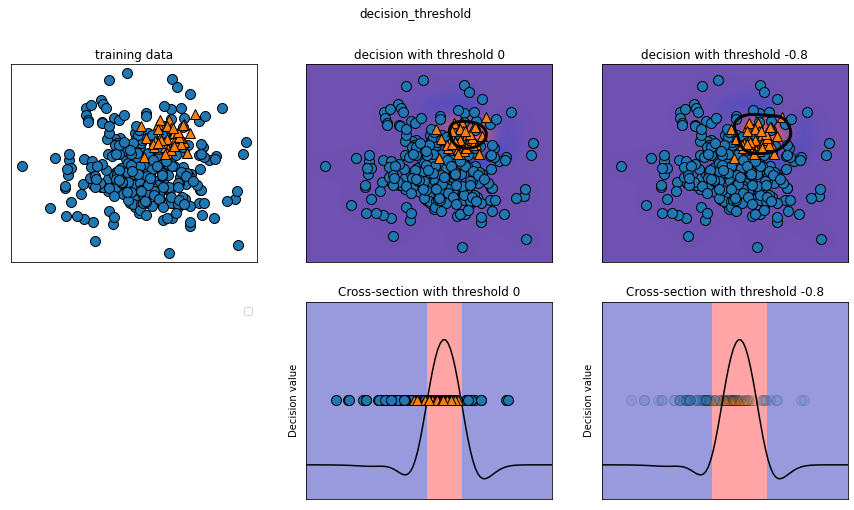

In [131]:
# 下边是一个平衡二分类任务的实例 ,反类中有400个点 ,而正类中只有50个点
# 在这个数据上训练一个核SVM模型 ,将决策函数绘制为热图 
# 可以在图像片上的位置看到一个黑色圆圈 ,表示decision_function 的阈值刚好为0
# 在这个圆圈内的点将被划为正类 ,圆圈外的点将被划为反类

from mglearn.datasets import make_blobs
X , y = make_blobs(n_samples =(400 ,50) , centers = 2 ,cluster_std = [7.0 ,2] , random_state = 22)
X_train , X_test, y_train , y_test = train_test_split(X , y , random_state = 0)
svc = SVC(gamma = 0.05).fit(X_train ,y_train)

mglearn.plots.plot_decision_threshold()

In [132]:
# 可以使用classification_report 函数来评估两个类别的准确率和召回率

In [133]:
print(classification_report(y_test , svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

    accuracy                           0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



In [134]:
# 对于类别1 ,得到了一个相当低的准确率 ,而召回率则令人糊涂(mixed)
# 由于类别0要大的多 ,所以分类器将重点放再将类别0分类正确 ,而不是较小的类别1

# 假设在我们应用中 ,类别具有高召回率更加重要 ,正如前面的例子那样
# 这意味着我们愿意冒险有更多的假正例(假的类别1) ,以换取更多的真正例(可正大召回率)
# svc.predict生成的预测无法满足这个要求 ,但我们可以通过改变决策阈值不等于0来将预测重点放再使类别1的召回率更高
# 默认情况下 ,decision_function值大于0的点将被划为类别1 ,
# 我们希望将更多的点划为类别1 ,所欲需要减小阈值

In [135]:
y_pred_lower_threshold = svc.decision_function(X_test)> -0.8

print(classification_report(y_test ,y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

    accuracy                           0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



In [136]:
# 类别1的召回率增大 ,准确率减小 
# 现在将更大的空间区域划为类别1

# 若认为准确率比召回率更公钥 ,或者反过来 ,或者你的数据严重不平衡
# 那么改变决策阈值时得到更好结果的最简单方法
# 由于decision_function 的取值可能在任意范围 ,所以很难提供关于如何选取阈值的经验法则

In [137]:
# 如果你设置了阈值 ,那么要小心不要再测试集上这么做
# 与其他任何参数一样 ,在测试集上设置决策阈值可能会得到过于乐观的结果
# 可以使用验证集或交叉验证来代替

In [138]:
# 对于实现了predict_proba 方法的模型来说 ,选择阈值可能更简单 
# 因为predict_proba 的输出固定在0到1的范围内 ,表示的是概率

# 默认情况下 ,0.5的阈值表示 ,如果模型以超过50%'确信'一个点属于正类 ,那么就将其划为正类
# 增大这个阈值意味着模型需要更加确信才能做出正类的判断(较低程度的确信就可以做出反类的判断)

# 虽然使用概率可能比使用任意阈值更加直观 ,但并非所有模型都能提供了不确定性的实际模型
# (一颗生长到最大深度的DecisionTree 总是100% 确信其判断 ,即使很可能是错的)

# 这与校准(calibration)的概念相关:
# 校准模型是指能够为其不确定性提供精确度量的模型

##### 5. 准确率-召回率曲线

In [139]:
# 改变模型中用于做出分类决策的阈值 ,是一种调节给定分类器的准确率和召回率之间折中的方法

# 可能希望仅遗漏不到10%的正类样本 ,即希望召回率能达到90% 
# 这以决策取决于应用 ,应该是由商业目标驱动的
# 一旦设定了一个具体目标(比如对某类别的特定召回率或准确率),就可以是当地设定一个阈值
# 总是可以设置一个阈值来满足特定的目标 ,比如90%的召回率
# 难点在于开发一个模型 ,在满足这个阈值的同时仍具有合理的准确率
# 如果将所有样本都划为正类 ,那么将会得到100%的召回率 , 但你的模型毫无用处

In [140]:
# 对分类器设置要求(比如90%的召回率)通常被称为设置工作点(operating point)

In [141]:
# 在开发新模型时 ,通常并不完全清楚工作点在哪里
# 因此 ,为了更好地理解建模问题 ,很由启发性的做法是 ,同时查看所有可能的阈值或准确率和召回率的所有可能折中
# 利用一种叫做准确率-召回率曲线(precision-recall curve)的工具可以做到这一点
# 可以在sklearn,metrics模块中找到计算准确率-召回率曲线的函数
# 这个函数需要真实标签与预测的不确定度 ,后者由decision_function 或 predict_proba给出:

In [142]:
from sklearn.metrics import precision_recall_curve
precision , recall , thresholds = precision_recall_curve(y_test , svc.decision_function(X_test))

In [143]:
# precision_recall_curve函数返回一个列表
# 包含按顺序排序的所有可能阈值(在决策函数中出现的所有值)对应的准确率和召回率

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


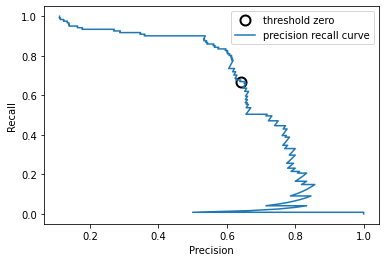

In [144]:
# 使用更多数据点来得到更加平滑的曲线
X , y = make_blobs(n_samples = (4000 , 500) , centers = 2 ,cluster_std = [7.0 ,2] ,random_state = 22)
X_train , X_test , y_train , y_test = train_test_split(X , y , random_state = 0)
svc = SVC(gamma = 0.05).fit(X_train , y_train)
precision , recall ,thresholds = precision_recall_curve(y_test ,svc.decision_function(X_test))
# 找到最接近于0的阈值
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero] , recall[close_zero] ,'o' ,markersize = 10 , 
         label = 'threshold zero' , fillstyle = 'none' ,c = 'k',mew = 2)

plt.plot(precision , recall , label = 'precision recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc = 'best')

plt.show()

In [145]:
# 在曲线上的每一个点都对应decision_function的一个可能的阈值
# 黑色圆圈按表示的是阈值为0的点
# 0是decision_function的默认阈值 
# 这个点是在调用predict方法时所选择的折中点

In [146]:
# 曲线越靠近右上角 ,则分类器越好
# 右上角的点表示对于同一个阈值 ,准确率和召回率都很高
# 曲线从左上角开始 ,这里对应于非常低的阈值 ,将所有样本都划为正类
# 提高阈值可以让曲线向准确率更高的方向移动 ,但同时召回率降低
# 继续增大阈值 ,大多数被划为正类的点都是真正例 ,此时准确率很高 ,但召回率更低
# 随着准确率的升高 ,模型越能够保持较高的召回率 ,则模型越好

In [147]:
# 进一步观察这条曲线 ,可以发现 ,利用这个模型可以得到约0.5的准确率 ,同时保持很高的召回率
# 如果想要更高的准确率 ,那么就必须牺牲很多召回率
# 换句话说 ,曲线左侧相对平坦 ,说明在准确率提高的同时召回率没有下降很多
# 当准确率大于0.5之后 ,准确率每增加一点都会导致召回率下降很多

In [148]:
# 不同的分类器可能在曲线上不同的位置(即在不同的工作点)表现很好

In [149]:
# 比较一下在同一数据集上训练的SVM与随机森林
# RandomForestClassifier 没有decision_function ,只有predict_proba
# predict_recall_curve 函数的第二个参数应该是正类(类别1)的确定性度量
# 所以传入样本属于类别1的概率(即rf.predict_proba(X_test)[:, 1])
# 二分类问题的predict_proba 的默认阈值时0.5 ,所以在曲线上标出这个点

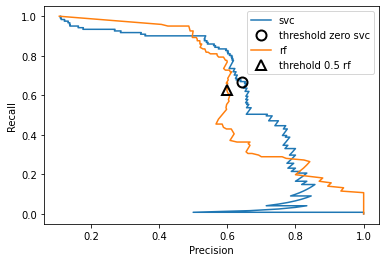

In [150]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100 , random_state = 0 , max_features = 2)
rf.fit(X_train , y_train)

# RandomForestClassifier 有predict_proba , 但没有decision_function
precision_rf , recall_rf , thresholds_rf = precision_recall_curve(y_test ,rf.predict_proba(X_test)[:, 1])

plt.plot(precision , recall , label = 'svc')
plt.plot(precision[close_zero] , recall[close_zero] ,'o' ,markersize = 10 ,
        label = 'threshold zero svc' , fillstyle = 'none' ,c = 'k' ,mew = 2)

plt.plot(precision_rf , recall_rf , label ='rf')

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf] , recall_rf[close_default_rf] , '^' ,c = 'k' ,
        markersize = 10 , label = 'threhold 0.5 rf' , fillstyle = 'none' , mew = 2)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc = 'best')
plt.show()

In [151]:
# 从这张对比图中可以看出 ,随机森林在极值处(要求很高的召回率或很高的准确率)的表现很好
# 在中间位置(准确率约为0.7)SVM的表现更好
# 如果只查看f1-分数来比较二者的总体性能 ,那么可能会遗漏这些细节
# f1-分数只反应了准确率-召回率曲线上的一个点 ,即默认阈值对应的点

In [152]:
print('f1_score of random forest:{:.3f}'.format(f1_score(y_test , rf.predict(X_test))))
print('f1_score of svc :{:.3f}'.format(f1_score(y_test , svc.predict(X_test))))

f1_score of random forest:0.610
f1_score of svc :0.656


In [153]:
# 比较这两条准确率-召回率曲线 ,可以为我们提供大量详细的洞见 ,但这是一个相当麻烦的过程
# 对于自动化模型对比 ,可能希望总结曲线中包含的信息 ,而不限于某个特定的阈值或工作点
# 总结正确率 - 召回率曲线的一种方法时计算该曲线下的积分或面积 , 也叫做平均准确率(average percision)
# 可以使用average_precision_score 函数来计算平均准确率
# 因为我们要计算准确率-召回率曲线并考虑多个阈值 ,所以需要向average_precision_score传入decision_function或predict_proba的结果
# 而不是predict的结果

In [154]:
from sklearn.metrics import average_precision_score

ap_rf = average_precision_score(y_test , rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test , svc.decision_function(X_test))

print('Average precision of random forest :{:.3f}'.format(ap_rf))
print('Average precision of svc:{:.3f}'.format(ap_svc))

Average precision of random forest :0.660
Average precision of svc:0.666


In [155]:
# 在对所有可能的阈值进行平均时 ,看到随机森林和SVC的表现差不多好 ,随机森林稍稍领先
# 这与前面从f1_score 中得到的结果大为不同
# 因为平均准确率是从0到1的曲线下的面积 ,所以平均准确率总是返回一个在0(最差)到1(最好)之间的值
# 随机分配decision_function 的分类器的平均准确率是数据集中正例样本所占的比例

##### 6. 受试者工作特征(ROC)与AUC

In [156]:
# 还有一种常用的工具可以分析不同阈值的分类器行为
# 受试者工作特征曲线(receiver opearting characteristics curves) ,简称为ROC曲线(ROC curve)
# 与准确率-召回率曲线类似,ROC曲线考虑了给定分类器的所有可能的阈值 
# 但它显示的是假正例率(false positive rate ,FPR)和真正例率(true positive rate ,TPR) ,而不是报告准确率和召回率
# 回想一下 ,真正例率只是召回率的另一个名称 ,而假正例率则是假正例占所有反类样本的比例

FPR = $\frac{FP}{FP + TN}$

In [157]:
# 可以用 roc_curve函数来计算ROC曲线

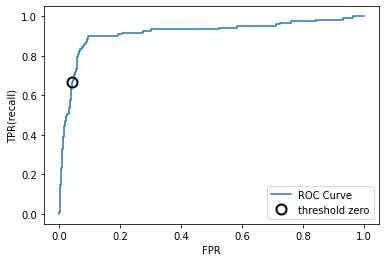

In [158]:
from sklearn.metrics import roc_curve
fpr , tpr , thresholds = roc_curve(y_test ,svc.decision_function(X_test))

plt.plot(fpr , tpr , label = 'ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')
# 找到最接近于0的阈值
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero] ,tpr[close_zero] , 'o' , markersize = 10 ,label = 'threshold zero' , fillstyle = 'none' ,c = 'k' ,mew = 2)
plt.legend(loc = 4)
plt.show()

In [159]:
# 对于ROC曲线 ,理想的曲线要靠近左上角
# 希望分类器的召回率很高 ,同时保持假正例率很低

# 从曲线中可以看出 ,与默认阈值0相比 ,可以得到明显更高的召回率(约0.9),而FPR仅稍有增加
# 最接近左上角的点可能是比默认选择更好的工作点
# 同样请注意 ,不应该在测试集上选择阈值 ,而是应该在单独的验证集上选择

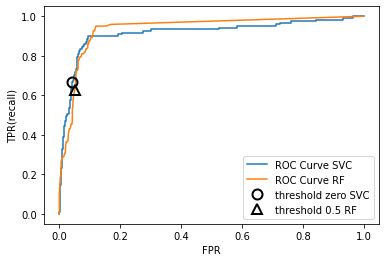

In [160]:
# 随机森林和SVM的ROC曲线对比

from sklearn.metrics import roc_curve
fpr_rf ,tpr_rf , thresholds_rf = roc_curve(y_test , rf.predict_proba(X_test)[:, 1])

plt.plot(fpr , tpr ,label = 'ROC Curve SVC')
plt.plot(fpr_rf , tpr_rf , label = 'ROC Curve RF')

plt.xlabel('FPR')
plt.ylabel('TPR(recall)')
plt.plot(fpr[close_zero] , tpr[close_zero] , 'o' , markersize = 10 , 
         label = 'threshold zero SVC' , fillstyle = 'none' ,c = 'k' ,mew = 2)

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf] , tpr_rf[close_default_rf] , '^' , markersize = 10 
         , label = 'threshold 0.5 RF' ,fillstyle = 'none' ,c = 'k' ,mew = 2)

plt.legend(loc = 4)
plt.show()

In [161]:
# 与准确率-召回率曲线一样 ,通常希望使用一个数字来总结ROC曲线
# 即曲线下的面积 ,通常被称为AUC(area under the curve) ,这里的曲线值得就是ROC曲线
# 可以利用roc_auc_score函数来计算ROC曲线下的面积

In [162]:
from sklearn.metrics import roc_auc_score

rf_auc = roc_auc_score(y_test ,rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test ,svc.decision_function(X_test))
print('AUC for Random Forest:{:.3f}'.format(rf_auc))
print('AUC for SVC:{:.3f}'.format(svc_auc))

AUC for Random Forest:0.937
AUC for SVC:0.916


In [163]:
# 利用AUC分数来比较随机森林和SVM ,发现随机森林的表现比SVM要略好一点
# 由于平均准确率是从0 到1 的曲线下的面积 ,所以平均准确率总是返回一个0(最差) 到1(最好)之间的值
# 随机预测得到的AUC总是0.5 ,无论数据集中的类别多么不平衡
# 对于不平衡的分类问题来说 ,AUC是一个比精度好得多的指标
# AUC可以被解释为评估正例样本的排名(ranking)
# 它等价于正类样本中随机挑选一个点 ,由分类器给出的分数比反类样本中随机挑选一个点的分数更高的概率
# 因此 ,AUC最高为1 ,这说明所有正类点的分数高于所有反类点
# 对于不平衡类别的分类问题 ,使用AUC进行模型选择通常比使用精度更有意义

In [164]:
# 将digits 数据集中的所有9与所有其他数据加以区分
# 将使用SVM对数据集进行分类 ,分别使用三种不同的内核宽度(gamma)设置

gamma = 1.00 accuracy = 0.90 AUC = 0.50
gamma = 0.05 accuracy = 0.90 AUC = 1.00
gamma = 0.01 accuracy = 0.90 AUC = 1.00


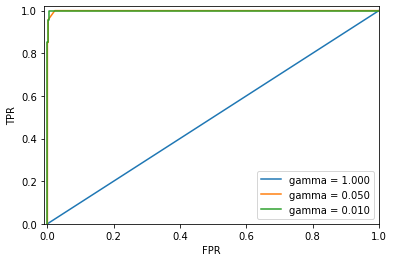

In [165]:
y = digits.target == 9

X_train , X_test , y_train , y_test = train_test_split(digits.data ,y , random_state = 0)

plt.figure()

for gamma in [1 , 0.05 , 0.01]:
    svc = SVC(gamma = gamma).fit(X_train , y_train)
    accuracy = svc.score(X_test , y_test)
    auc = roc_auc_score(y_test ,svc.decision_function(X_test))
    fpr ,tpr , _ = roc_curve(y_test ,svc.decision_function(X_test))
    print('gamma = {:.2f} accuracy = {:.2f} AUC = {:.2f}'.format(gamma ,accuracy ,auc))
    plt.plot(fpr , tpr , label = 'gamma = {:.3f}'.format(gamma))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.01 , 1)
plt.ylim(0 , 1.02)
plt.legend(loc = 'best')
plt.show()

In [166]:
# 对于三种不同的gamma设置 ,其精度是相同的 ,都等于90%
# 这可能与随机选择的性能相同 ,也可能不同
# 但是观察AUC以及对应的曲线 ,可以看到三个模型之间有明显的区别
# 对于gamma = 1.0 ,AUC实际上处于随机水平 ,即decision_function 的输出与随机结果一样好
# 对于gamma = 0.05 ,性能大幅提升至AUC等于0.9
# 最后 ,对于gamma = 0.01,得到等于1.0 的完美AUC

In [167]:
# 这意味着根据决策函数 ,所有正类点的排名要高于所有反类点
# 换句话说 ,利用正确的阈值 ,这个模型可以对所有数据进行完美分类
# 知道这一点 ,可以调节这个模型的阈值并得到很好的预测结果
# 如果我们仅使用精度 ,那么将永远不会发现这一点

In [168]:
# 因此 ,强烈建议在不平衡数据上评估模型时使用AUC
# AUC 没有使用默认阈值 
# 因此 ,为了从高AUC的模型中得到有用的分类结果 ,可能还需要调节决策阈值

### 多分类指标

In [169]:
# 多分类问题的所有指标基本上都来自于二分类指标 ,但是要对所有类别进行平均
# 多分类的精度被定义为正确分类的样本所占的比例

# 同样 ,如果类别是不平衡的 ,精度并不是很好的评估度量
# 除了精度 ,常用的工具有混淆矩阵和分类报告 

In [170]:
# 将这两种详细的评估方法应用于对digits数据集中10种不同的手写数字进行分类的任务

In [171]:
from sklearn.metrics import accuracy_score
X_train , X_test , y_train , y_test = train_test_split(digits.data , digits.target , random_state = 0)
lr = LogisticRegression(max_iter = 5000).fit(X_train , y_train)
pred = lr.predict(X_test)
print('Accuracy:{:.3%}'.format(accuracy_score(y_test , pred)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test , pred)))

Accuracy:95.333%
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  2  1]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  0 44  0  0  0  0  1  0]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  0  2]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  1  1  0  0 46  0  0]
 [ 0  3  1  0  0  0  1  0 43  0]
 [ 0  0  0  0  0  1  0  0  2 44]]


In [172]:
# 模型的精度为95.3% , 这表示已经做的相当好了
# 混淆矩阵为我们提供了更多的细节
# 与二分类的情况相同 ,每一行对应于真实标签 ,每一列对应于预测标签

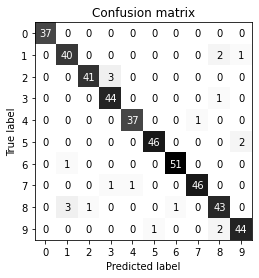

In [173]:
scores_images = mglearn.tools.heatmap(confusion_matrix(y_test , pred) 
                                      ,xlabel = 'Predicted label' ,ylabel = 'True label' ,xticklabels = digits.target_names,
                                     yticklabels = digits.target_names , cmap = plt.cm.gray_r ,fmt = '%d')
plt.title('Confusion matrix')
plt.gca().invert_yaxis()

In [174]:
# 对于第一个类被(数字0) ,它包含37个样本 ,所有这些样本都被划分类别0(即类别0没有假反例)
# 之所以能看出这一点 ,是因为混淆矩阵第一行中其他所有元素都为0

# 还可以看到 ,没有其他数字被误分类为类别0 ,这是因为混淆矩阵第一列中其他所有元素都为0(即类别0没有假正例)
# 但是有些数字与其他数字混在一起
# 比如数字2(第三行),其中有3个被划分到数字3中(第4列)
# 还有一个数字3 被划分到数字2中(第4行第3列) ,一个数字8被划分到数字2中(第9行第3列)

In [175]:
# 利用classification_report 函数 ,可以计算每个类别的准确率 ,召回率 和 f-分数

In [176]:
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.91      0.93      0.92        43
           2       0.98      0.93      0.95        44
           3       0.92      0.98      0.95        45
           4       0.97      0.97      0.97        38
           5       0.98      0.96      0.97        48
           6       0.98      0.98      0.98        52
           7       0.98      0.96      0.97        48
           8       0.90      0.90      0.90        48
           9       0.94      0.94      0.94        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



In [177]:
# 不出所料 ,类别0的准确率和召回率都是完美的1 ,因为这个类别中没有混淆
# 另一方面 ,对于类别7 ,准确率为1 ,这是因为没有其他类别被误分类为7
# 而类别6没有假反例 ,所以召回率等于1 
# 模型对类别8和类别3的表现特别不好

In [178]:
# 对于多分类问题中的不平衡数据集 ,最常用的指标就是多分类版本的f-分数
# 多分类f-分数背后的想法是
# 对每个类别计算一个二分类f-分数 ,其中该类别是正类 ,其他所有类别组成反类
# 然后 ,使用以下策略之一对这些按类别f-分数进行平均

# '宏'(macro)平均 : 计算未加权的按类别f-分数
# 它对所有类别给出相同的权重 ,无论类别中的样本量大小

# '加权'(weighted)平均 : 以每个类别的支持作为权重来计算按类别f-分数的平均值
# 分类报告中给出的就是这个值

# '微'(micro)平均 : 计算所有类别中假正例,假反例 和真正例的总数 ,然后利用这些计数来计算准确率 ,召回率和f-分数

In [179]:
# 如果对每个样本等同看待 ,那么推荐使用'微'平均f1-分数
# 如果对每个类别等同看待 ,那么推荐使用'宏'平均f1-分数

In [180]:
print('Micro average f1 score:{:.3f}'.format(f1_score(y_test ,pred ,average = 'micro')))
print('Macro average f1 score:{:.3f}'.format(f1_score(y_test ,pred ,average = 'macro')))

Micro average f1 score:0.953
Macro average f1 score:0.954


### 回归指标

In [181]:
# 对回归问题可以向分类问题一样进行详细评估
# 例如 ,对目标值估计过高与目标值估计过低进行对比分析
# 但是 ,对于我们见过的大多数应用来说 ,使用默认R^2就足够了 ,它由所有回归器的score方法给出
# 业务决策有时是根据均方误差或平均绝对误差做出的 ,这可能会鼓励人们使用这些指标来调节模型
# 但一般来说 ,认为R^2是评估回归模型的更直观的指标

### 在模型选择中使用评估指标

In [182]:
# 我们通常希望 ,在使用GridSearchCV 或 cross_val_score 进行模型选择是能够使用AUC等指标

# 幸运的是 ,scikit-learn提供了一种非常简单的实现方法 ,就是scoring参数
# 它同时用于GridSearchCV 和cross_val_score
# 只需提供一个字符串 ,用于描述想要使用的评估指标

# 举个例子 ,向用AUC分数对digits数据集中'9与其他'任务上的SVM分类器进行评估
# 想要将分数从默认值(精度)修改为AUC ,可以提供'roc_auc'作为scoring参数的值

In [183]:
# 分类问题的默认评分是精度
print('Default scoring:{}'.format(cross_val_score(SVC() ,digits.data , digits.target == 9)))
                                  
# 指定scoring = 'accuracy' 不会改变结果
explicit_accuracy = cross_val_score(SVC() , digits.data , digits.target == 9 , scoring = 'accuracy')

print('Explicit accuracy scoring:{}'.format(explicit_accuracy))
roc_auc = cross_val_score(SVC() ,digits.data ,digits.target == 9 ,scoring = 'roc_auc')
print('AUC scoring :{}'.format(roc_auc))

Default scoring:[0.975      0.99166667 1.         0.99442897 0.98050139]
Explicit accuracy scoring:[0.975      0.99166667 1.         0.99442897 0.98050139]
AUC scoring :[0.99717078 0.99854252 1.         0.999828   0.98400413]


In [184]:
# 类似地 ,可以改变GridSearchCV 中用于选择最佳参数的指标

In [185]:
X_train , X_test , y_train ,y_test = train_test_split(digits.data ,digits.target == 9 , random_state = 0)

# 给出了不太好的网格来说明
param_grid = {'gamma':[0.0001 , 0.001 , 0.1 , 1 , 10]}
# 使用默认的精度
grid = GridSearchCV(SVC() , param_grid = param_grid)
grid.fit(X_train , y_train)
print('Grid-Search with accuracy')
print('Best parameters:' , grid.best_params_)
print('Best cross-validation score (accuracy):{:.3f}'.format(grid.best_score_))
print('Test set AUC:{:.3f}'.format(roc_auc_score(y_test , grid.decision_function(X_test))))
print('Test set accuracy :{:.3f}'.format(grid.score(X_test , y_test)))

Grid-Search with accuracy
Best parameters: {'gamma': 0.001}
Best cross-validation score (accuracy):0.996
Test set AUC:1.000
Test set accuracy :0.991


In [186]:
# 使用AUC评分来代替
grid = GridSearchCV(SVC() , param_grid = param_grid, scoring = 'roc_auc')
grid.fit(X_train , y_train)
print('\n Grid-Search with AUC')
print('Best parameters:',grid.best_params_)
print('Best cross-validation score(AUC):{:.3f}'.format(grid.best_score_))
print('Test set AUC :{:.3f}'.format(roc_auc_score(y_test , grid.decision_function(X_test))))
print('Test set accuracy :{:.3f}'.format(grid.score(X_test ,y_test)))


 Grid-Search with AUC
Best parameters: {'gamma': 0.001}
Best cross-validation score(AUC):0.999
Test set AUC :1.000
Test set accuracy :1.000


In [187]:
# 在使用精度时 ,选择的参数时gamma = 0.0001 ,而使用AUC时选择的参数是gamma = 0.01
# 在两种情况下 ,交叉验证精度与测试集精度是一致的
# 但是 ,使用AUC找到的参数设置 ,对应的AUC更高 ,甚至对应的精度也更高

In [188]:
# 对应分类问题 ,scoring参数最重要的取值包括 : 
# accuracy(默认值) ,roc-auc (ROC曲线下方的面积) ,average_precision(准确率 - 召回率曲线下方的面积)
# f1 , f1_macro , f1-micro 和 f1_weighted (这四个是二分类的f1-分数以及各种加权变体)

# 对于归回问题 ,最常用的取值包括:
# r2 (R^2分数) , mean_squared_error(均方误差) 和 mean_absolute_error(平均绝对误差)

In [191]:
from sklearn.metrics import SCORERS
print('Available scorers:\n{}'.format(sorted(SCORERS.keys())))

Available scorers:
['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


## 小结与展望

In [190]:
# 本章由两个特别的要点

# 第一个要点与交叉验证有关
# 交叉验证或者使用测试集让我们可以评估一个机器学习模型未来的表现
# 但是 ,如果我们使用测试集或交叉验证来选择模型或者选择模型参数 ,那么我们就'用完了'测试数据
# 而使用相同的数据来评估模型未来的表现将会得到过于乐观的估计
# 因此 ,我们需要将数据集划分为训练数据 ,验证数据与测试数据 
# 其中训练数据用于模型建构 ,验证数据用于选择模型与参数 ,测试数据用于模型评估
# 我们可以用交叉验证来代替每一次简单的划分 
# 最常用的形式是训练/测试划分用于评估 ,然后对训练集使用交叉验证来选择模型与参数 

# 第二个要点与用于模型选择与模型评估的评估指标或评分函数有关
# 机器学习任务的最终目标很少是构建一个高精度的模型 
# 一定要确保用于模型评估与选择的指标能够很好地代替模型的实际用途
# 在实际当中 ,分类问题很少会遇到平衡的类别 ,假正例和假反例也挺具有非常不同的后果
# 一定要了解这些后果 ,并选择相应的评估指标